In [1]:
# Implementation of a Multinomial Logit using Tensorflow
# Follows examples in Fundamentals of Deep Learningm Chapter 3
# Using different dataset, sign-language-digits-dataset
# https://www.kaggle.com/ardamavi/sign-language-digits-dataset/home

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
# Load image data set
x_img = np.load('data/sign-language-digits-dataset/X.npy')
print(x_img.shape)
# Flatten to 2D array, 1 row per instance, consisting of a 64x64 = 4096 vector
x_l = x_img.reshape(x_img.shape[0],(x_img.shape[1]*x_img.shape[2]))
x_l.shape

(2062, 64, 64)


(2062, 4096)

In [4]:
# Load labels
Y_l = np.load('data/sign-language-digits-dataset/Y.npy')
Y_l.shape

(2062, 10)

In [5]:
# Data is currently sorted by labels
# Reorder the data randomly
reordering = np.random.choice(x_l.shape[0],size=x_l.shape[0], replace=False)
x_l = x_l[reordering]
Y_l = Y_l[reordering]

In [6]:
# Set image size
img_size = 64

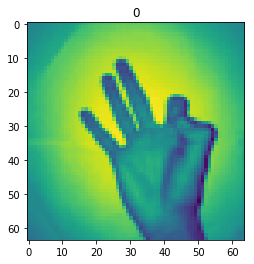

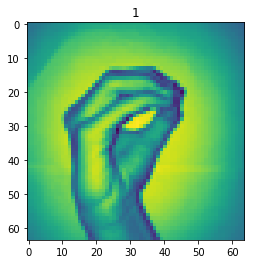

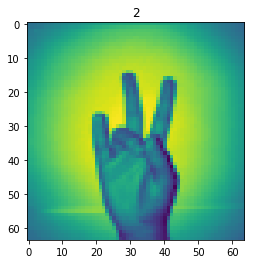

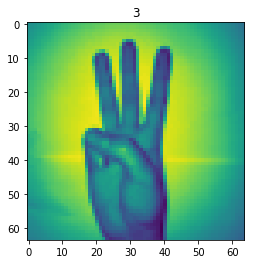

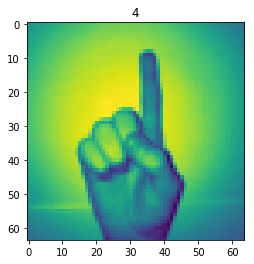

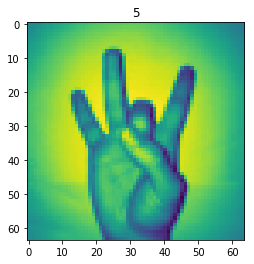

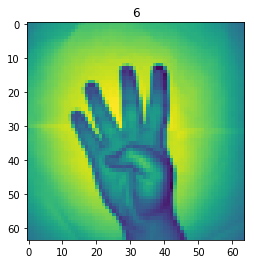

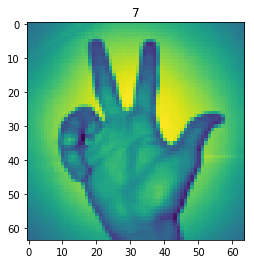

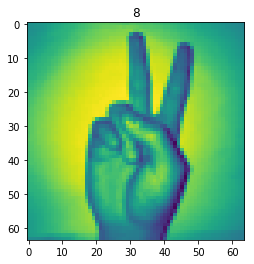

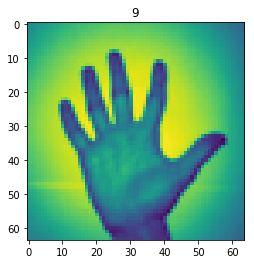

In [7]:
# Labels Y is a 1 x 10 vector of 0s and a 1; but the index of the 1 is not the actual digit.
# Explore the images to reconstruct a mapping between index of the 1 and digit value

# Loop through digits
for i in range(10):
    # Select all images with a given label
    select_img = x_l[np.argmax(Y_l,axis=1)==i]
    # Pick a random image
    for img in select_img[np.random.choice(range(select_img.shape[0]),1)]:
        plt.imshow(img.reshape(img_size, img_size))
        plt.title(i) # Print the label  (ie index of the 1 in Y_l)
        plt.show()

# Observation of the output allows reconstructing the mapping:
label_dict = {
                0:9,
                1:0,
                2:7,
                3:6,
                4:1,
                5:8,
                6:4,
                7:3,
                8:2,
                9:5
            }


In [8]:
# Set training parameters
learning_rate = 0.01
momentum = 0.9
training_epochs = 400
batch_size = 150
display_step = 1

In [9]:
def inference(x):
    # Define initialization strategy for variables if these not define
    init = tf.constant_initializer(value=0)
    # Retrive variables if exist, else intialize
    # The weights of the single 'layer' in a logistic regression
    W = tf.get_variable("W", [4096, 10], initializer=init)
    # The constant in a logistic regression 
    b = tf.get_variable("b", [10],initializer=init)
    # Convert output probabilities into softmax layer 
    output = tf.matmul(x, W) + b
    return output

def loss(output, y):
    # Calculates cross-entropy loss
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)
    return loss

def training(cost, global_step):
    # Log a scalar for training diagnostics
    tf.summary.scalar("cost", cost)
    # Set up optimizing algorithm
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    # Execute one optimization step
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

def evaluate(output, y):
    # Calculate accuracy score
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [10]:
# Split data into training, validation and test
X_train, X_test, y_train, y_test = train_test_split(x_l, Y_l, test_size=0.20, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [11]:
with tf.Graph().as_default():
    
    
    ##
    ##  SET UP GRAPH STRUCTURE 
    ##
    
    # Set up placeholder tensors
    
    # Data image of shape 64*64=4096
    x = tf.placeholder("float", [None, 4096])
    # 0-9 digits recognition => 10 classes
    y = tf.placeholder("float", [None, 10])
    
    # Define the high-level steps in the training graph
    # Determine prediction given input and current state of weights
    output = inference(x)
    # Calculate loss of prediction yeilded by previous step
    cost = loss(output, y)
    
    # Global step just counts the number of optimization steps taken. We intialize it to 0
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    # This line defines the main entrance to the graph for each training step
    train_op = training(cost, global_step)
    
    # Definte entrance to evaluation function 
    eval_op = evaluate(output, y)
    
    # Definte entrance to summary function 
    summary_op = tf.summary.merge_all()
    
    ##
    ## START THE TRAINING OPERATION
    ##
    
    # Set up session and logging
    saver = tf.train.Saver()
    sess = tf.Session()
    summary_writer = tf.summary.FileWriter("logs/logistic-regression/", graph=sess.graph)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # Start training cycle in epochs
    for epoch in range(training_epochs):
        
            avg_cost = 0.
            total_batch = int(X_train.shape[0]/batch_size)
            
            # Loop over all batches
            for i in range(0, X_train.shape[0], batch_size):
                
                # Get batch by slicing
                mbatch_x = X_train[i:i + batch_size]
                mbatch_y = y_train[i:i + batch_size]
                
                # Run a training step using a batch of data
                feed_dict = {x : mbatch_x, y : mbatch_y}
                sess.run(train_op, feed_dict=feed_dict)
                
                # Compute average loss
                minibatch_cost = sess.run(cost, feed_dict=feed_dict)
                avg_cost += minibatch_cost/total_batch
                
            # Display logs per epoch step
            if epoch % display_step == 0:
                val_feed_dict = {
                     x : X_validation,
                     y : y_validation
                }
                accuracy = sess.run(eval_op, feed_dict=val_feed_dict)
                print("Validation Error:", (1 - accuracy))
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, sess.run(global_step))
                saver.save(sess, "logs/logistic-regression/model-checkpoint", global_step=global_step)
                
    print("Optimization Finished!")
    test_feed_dict = {
             x : X_test,
             y : y_test
    }
    accuracy = sess.run(eval_op, feed_dict=test_feed_dict)
    print("Test Accuracy:", accuracy)
 

Validation Error: 0.9031476974487305
Validation Error: 0.9031476974487305
Validation Error: 0.8934624716639519
Validation Error: 0.8740920126438141
Validation Error: 0.900726392865181
Validation Error: 0.8861985504627228
Validation Error: 0.8159806281328201
Validation Error: 0.9031476974487305
Validation Error: 0.8692493885755539
Validation Error: 0.670702189207077
Validation Error: 0.685230016708374
Validation Error: 0.5907990336418152
Validation Error: 0.7723971009254456
Validation Error: 0.5762711763381958
Validation Error: 0.7578692436218262
Validation Error: 0.5811138153076172
Validation Error: 0.46973365545272827
Validation Error: 0.38256657123565674
Validation Error: 0.33898305892944336
Validation Error: 0.33656173944473267
Validation Error: 0.2953994870185852
Validation Error: 0.3123486638069153
Validation Error: 0.305084764957428
Validation Error: 0.2953994870185852
Validation Error: 0.3075060248374939
Validation Error: 0.3026634454727173
Validation Error: 0.3002421259880066
V

Validation Error: 0.5036319494247437
Validation Error: 0.5108958780765533
Validation Error: 0.513317197561264
Validation Error: 0.5012106597423553
Validation Error: 0.47215497493743896
Validation Error: 0.4213075041770935
Validation Error: 0.38014525175094604
Validation Error: 0.32929784059524536
Validation Error: 0.31719130277633667
Validation Error: 0.2978208065032959
Validation Error: 0.3026634454727173
Validation Error: 0.3026634454727173
Validation Error: 0.2953994870185852
Validation Error: 0.3099273443222046
Validation Error: 0.2978208065032959
Validation Error: 0.2929782271385193
Validation Error: 0.2978208065032959
Validation Error: 0.2978208065032959
Validation Error: 0.3002421259880066
Validation Error: 0.3002421259880066
Validation Error: 0.2857142686843872
Validation Error: 0.2905569076538086
Validation Error: 0.2978208065032959
Validation Error: 0.3002421259880066
Validation Error: 0.2978208065032959
Validation Error: 0.2929782271385193
Validation Error: 0.297820806503295

Predicted: 8
True: 8


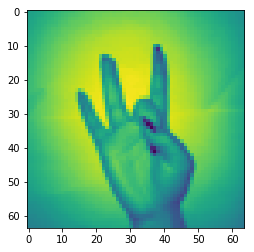

Predicted: 8
True: 8


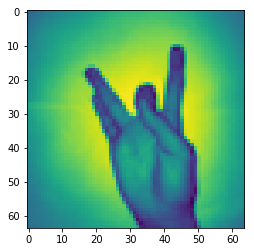

Predicted: 5
True: 5


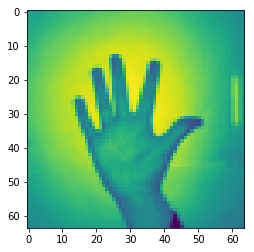

Predicted: 0
True: 0


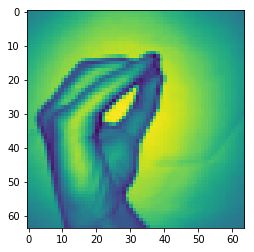

Predicted: 6
True: 6


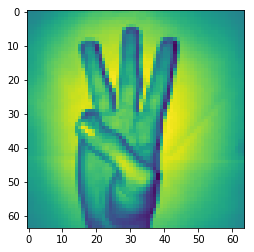

Predicted: 2
True: 2


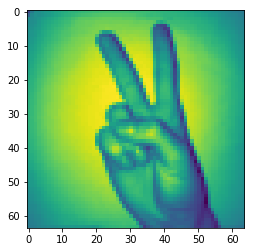

Predicted: 0
True: 0


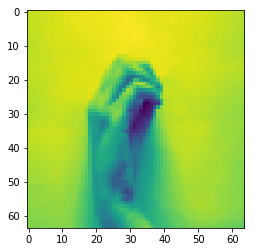

Predicted: 0
True: 0


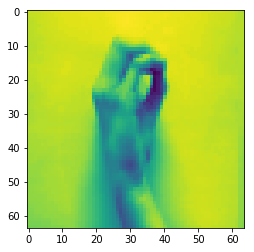

Predicted: 1
True: 1


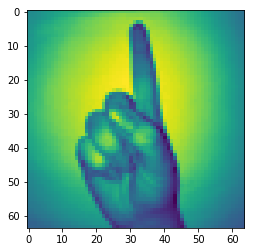

Predicted: 7
True: 7


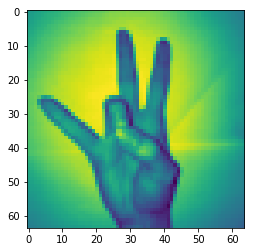

Predicted: 0
True: 0


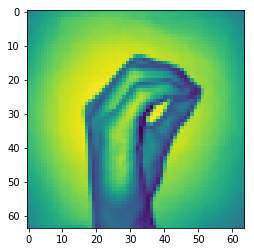

Predicted: 1
True: 1


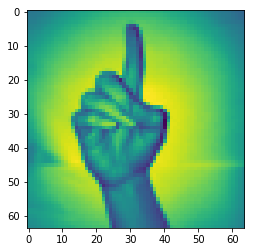

Predicted: 6
True: 6


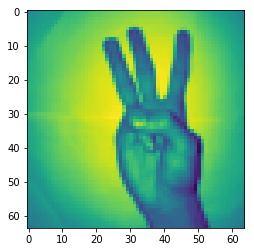

Predicted: 1
True: 1


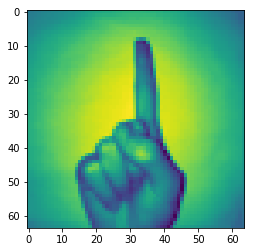

Predicted: 2
True: 2


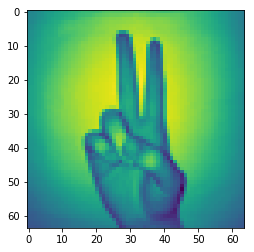

Predicted: 5
True: 5


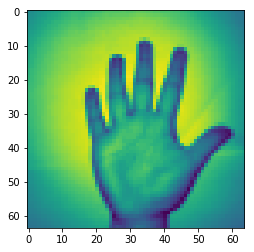

Predicted: 8
True: 8


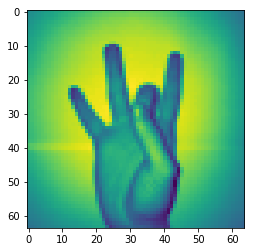

Predicted: 1
True: 1


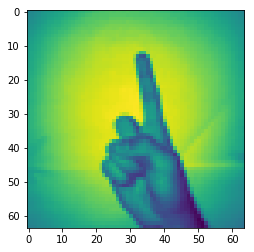

Predicted: 7
True: 7


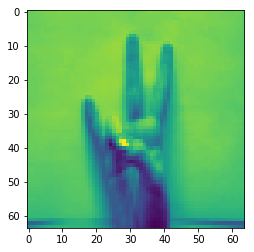

Predicted: 5
True: 5


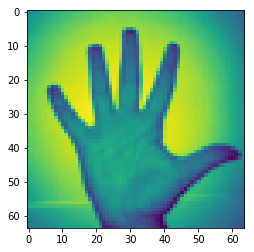

Predicted: 4
True: 4


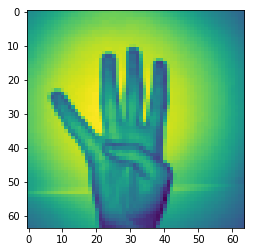

Predicted: 7
True: 2


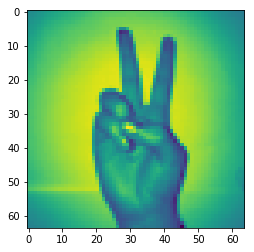

Predicted: 2
True: 2


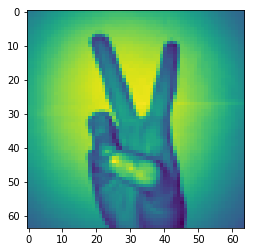

Predicted: 7
True: 7


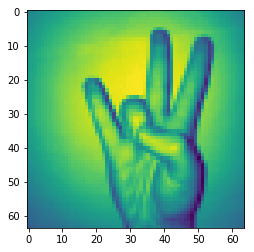

Predicted: 2
True: 2


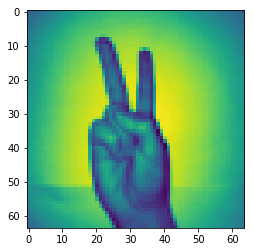

Predicted: 5
True: 5


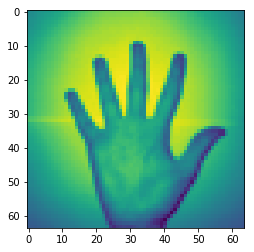

Predicted: 3
True: 6


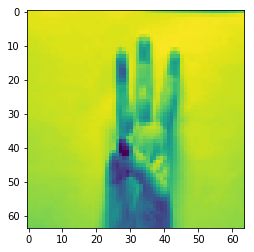

Predicted: 1
True: 1


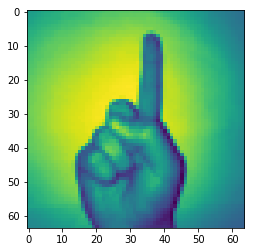

Predicted: 4
True: 4


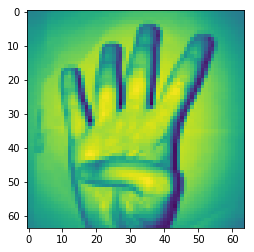

Predicted: 3
True: 3


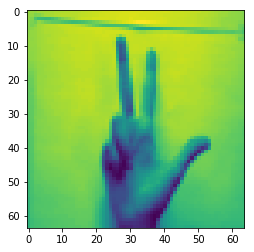

In [12]:
# Visualise the model predictions for a random set of instances
for i in np.random.choice(range(x_l.shape[0]),30):
        feed_dict = {x: x_l[i:i+1]}
        classification = sess.run(output, feed_dict)
        print("Predicted:",label_dict[np.argmax(classification, axis=1)[0]])
        print("True:",label_dict[np.argmax(Y_l[i])])
        plt.imshow(x_l[i].reshape(img_size, img_size))
        plt.show()